In [338]:
#Load and activate packages
using Pkg 
Pkg.activate("..")

"/home/jupyter/PharmacyEntry/Project.toml"

In [339]:
#Files we need
using Revise
if (!("../src" ∈ LOAD_PATH))
  push!(LOAD_PATH, "../src") 
end
using PharmacyEntry

In [340]:
#Just a quick check

nb = PharmacyEntry.loadNBdata(false);
bc = PharmacyEntry.loadBCdata(false);
mb = PharmacyEntry.loadMBdata(false);
nl = PharmacyEntry.loadNLdata(false);
pe = PharmacyEntry.loadPEdata(false);

In [341]:
using Statistics
using CSV

In [342]:
allProv = PharmacyEntry.loadpharmacydata();
census = PharmacyEntry.loadcensusdata();

checklatlng!(allProv, :lat, :lng, :zip)
@show mean(allProv[:zipmatch])


reading pharmacy data from /home/jupyter/PharmacyEntry/data/pharmacies.csv


┌ Info: reading cleaned census data from /home/jupyter/PharmacyEntry/data/popcentres.csv
└ @ PharmacyEntry /home/jupyter/PharmacyEntry/src/census.jl:145


mean(allProv[:zipmatch]) = 0.6708369283865401


0.6708369283865401

In [343]:
subset = (x->x ∈ ["British Columbia",
                  "Manitoba",
                  "Manitoba/Saskatchewan",
                  "New Brunswick",
                  "Newfoundland and Labrador",
                  "Prince Edward Island"]).(census[:PROV_TERR_NAME_NOM] )
df = census[subset,:]
    
    df[:pharmacies] = 0
function pharmcount(lat, lng ; data = df) 
    function distance_m(lng, lat, zlng, zlat) # wasn't calling from geo.jl for some reason
  if ismissing(lng) || ismissing(lat) || ismissing(zlng) || ismissing(zlat)
    missing
  else
    Geodesy.distance(Geodesy.LLA(lng, lat), Geodesy.LLA(zlng,zlat))
  end
end
  d = PharmacyEntry.distance_m.(lng, lat, data[:lng], data[:lat])
  (dm, i) = findmin(d)
  data[:pharmacies][i] = data[:pharmacies][i] + 1
end
    
#Creating an array for logitude and latitude
lat = allProv[:lat]
lat[ismissing.(lat)] .= allProv[:ziplat][ismissing.(lat)]
lng = allProv[:lng]
lng[ismissing.(lng)] .= allProv[:ziplng][ismissing.(lng)]

pharmcount.(lat,lng)
CSV.write("cleandata.csv",df);

In [344]:
#So not this is our new clean data frame with 221 metropolitan centres and the 
#the amount of corresponding pharmacies in each

CleanData = df;

In [345]:
using Distributions, DataFrames

"""
         brentrymodel(data::AbstractDataFrame,
                      n::Symbol,
                      s::Symbol,
                      x::Array{Symbol,1},
                      w::Array{Symbol,1};
                      Fϵ)

Create loglikelihood for Bresnehan & Reiss style entry model

Inputs:
- `data` DataFrame 
- `n` name of number of firm variable in data
- `s` name of market size variable in data
- `x` array of names of variable profit shifters
- `w` array of names of fixed cost shifters 
- `Fϵ` cdf of ϵ, optional, defaults to standard normal cdf

The same variables may be included in both `x` and `w`.
"""
function brentrymodel(data::AbstractDataFrame,
                      n::Symbol,
                      s::Symbol,
                      x::Array{Symbol,1},
                      w::Array{Symbol,1};
                      Fϵ = x->cdf(Normal(),x))
  # skip observations with missings
  vars = unique([n, s, x..., w...])
  inc = completecases(data[vars])

  N = disallowmissing(data[n][inc])
  S = disallowmissing(data[s][inc])
  X = disallowmissing(convert(Matrix, data[x][inc,:]))
  W = disallowmissing(convert(Matrix, data[w][inc,:]))
  Nmax = maximum(N)
  function packparam(α,β,γ,δ)
    θ = [α;β;γ;δ]
  end
  function unpackparam(θ)
    α = θ[1:Nmax]
    β = θ[(Nmax+1):(Nmax+size(X,2))]
    γ = θ[(Nmax+size(X,2)+1):(Nmax+size(X,2)+Nmax)]
    δ = θ[(Nmax+size(X,2)+Nmax+1):end]
    (α,β,γ,δ)
  end

  # While maximizing the likelihood some parameters might result in
  # the likelihood being 0 (or very close to 0) taking log would 
  # create problems. Use logfinite from PharmacyEntry.jl instead
  logf = logfinite(exp(-100.0) ) # could adjust the exp(-100.0)

  function loglike(θ)
    (α,β,γ,δ) = unpackparam(θ)
           
    P = Array{eltype(θ),1}(undef,length(N)) 

    for i in 1:length(N)
        if N[i]==0
            n = N[i]
            P[i] = Fϵ(-(S[i]*(α[1]+sum(X[i,:].*β))-(γ[1]+sum(W[i,:].*δ))))
    
        elseif N[i]==Nmax
            n = N[i]
            P[i] = 1-Fϵ(-(S[i]*((α[1]+sum(X[i,:].*β)+sum(α[2:n])))-(γ[1]+sum(W[i,:].*δ)+sum(γ[2:n]))))
            
        else
            n = N[i]
            P[i] = Fϵ(-(S[i]*(α[1]+sum(X[i,:].*β)+sum(α[2:n+1]))-(γ[1]+sum(W[i,:].*δ)+sum(γ[2:n+1]))))-Fϵ(-(S[i]*(α[1]+sum(X[i,:].*β)+sum(α[2:n]))-(γ[1]+sum(W[i,:].*δ)+sum(γ[2:n]))))
        end               
    end
    return(mean(logf.(P)))             
  end
    return(loglike=loglike, unpack=unpackparam, pack=packparam)
end

brentrymodel

### Problem 2: estimate on simulated data 

In [346]:
# Simulating data
using DataFrames, Statistics, StatsBase
import CSV
df = CSV.read("cleandata.csv")

# Important to scale variables to avoid numerical problems in both
# simulation & estimation
df[:pop10k] = df[Symbol("Population, 2016")]./10000
df[:logpop10k] = log.(df[:pop10k])
df[:income10k] = df[Symbol("Average total income in 2015 among recipients (\$)")]./10000
df[:density1k] = df[Symbol("Population density per square kilometre")]./1000
df[:logdensity] = log.(df[:density1k])
df[:logarea] = log.(df[Symbol("Land area in square kilometres")])
df[:mediumage] = df[Symbol("15 to 64 years")]./100
# parameters for simulation
n_obs_sim = 10000 # you might want to adjust this. You want it to be
                # large enough that your estimates are close to the
                # true values, but small enough that it doesn't take
                # too long to estimate

# the maximum number of pharmacies in the simulated data will be
# length(α) + 1
α = [1.0, -1.0]
γ = [1.0, 1.0]
# you may have to adjust the parameters to get a reasonable distribution of
# number of pharmacies across markets
svar = :pop10k
β = [1.0, 1.0]
xvars = [:income10k,
         :mediumage]
δ = [1.0, 1.0]
wvars = [:logdensity,
         :logarea]
simdf = df[sample(1:nrow(df), n_obs_sim),:]

simdf[:nsim] = brentrysim(simdf, svar, xvars, wvars, α,β,γ,δ)
println("Distribution of number of firms")

Distribution of number of firms


In [347]:
for i in 0:length(α)
  println("$(mean(simdf[:nsim].==i))") 
end

0.43
0.2615
0.3085


In [348]:
(loglike, unpack, pack) = brentrymodel(simdf, :nsim, svar, xvars, wvars)
θ0 = pack(α,β,γ,δ)
loglike(θ0)

-0.6424985179708318

To estimate from the simulated data, you could do the following.

In [349]:
using Optim, ForwardDiff, LinearAlgebra, PrettyTables
try 
  using EntrySolution
  # this contains my code for the likelihood and
  # it's intentionally not included in the assignment
catch
end

(loglike, unpack, pack) = brentrymodel(simdf, :nsim, svar, xvars, wvars)
θ0 = pack(α,β,γ,δ)
loglike(θ0)

# initial values --- note that you may run into optimization problems
# with poor initial values. This is especially likely if
# s*cumsum(α)[c] - cumsum(γ)[c] is not decreasing with c. You can
# ensure this by making α < 0 and γ>0
βi = zeros(size(β))
δi = zeros(size(δ))
αi = zeros(size(α))
γi = ones(size(γ))
θi = pack(αi, βi, γi, δi);
loglike(θi)

 res = optimize((x)->(-loglike(x)), θ0, method=BFGS(),
               autodiff=:forward, show_trace=true)

Iter     Function value   Gradient norm 
     0     6.424985e-01     1.682008e-02
     1     6.424390e-01     6.593116e-03
     2     6.422767e-01     2.077515e-03
     3     6.422002e-01     7.225123e-03
     4     6.421648e-01     3.491131e-03
     5     6.420795e-01     1.110681e-03
     6     6.420745e-01     1.782356e-03
     7     6.420664e-01     2.047087e-04
     8     6.420643e-01     2.047581e-03
     9     6.420539e-01     1.929309e-04
    10     6.420533e-01     6.438564e-04
    11     6.420405e-01     1.335118e-04
    12     6.420405e-01     3.241849e-05
    13     6.420403e-01     7.805210e-05
    14     6.420350e-01     1.355272e-04
    15     6.420350e-01     8.200059e-08
    16     6.420350e-01     2.703209e-10


Results of Optimization Algorithm
 * Algorithm: BFGS
 * Starting Point: [1.0,-1.0,1.0,1.0,1.0,1.0,1.0,1.0]
 * Minimizer: [1.0019431034459867,-1.1780022078176702, ...]
 * Minimum: 6.420350e-01
 * Iterations: 16
 * Convergence: true
   * |x - x'| ≤ 0.0e+00: false 
     |x - x'| = 1.02e-05 
   * |f(x) - f(x')| ≤ 0.0e+00 |f(x)|: false
     |f(x) - f(x')| = 9.16e-14 |f(x)|
   * |g(x)| ≤ 1.0e-08: true 
     |g(x)| = 2.70e-10 
   * Stopped by an increasing objective: false
   * Reached Maximum Number of Iterations: false
 * Objective Calls: 61
 * Gradient Calls: 61

In [350]:
# if you have problems, maybe look at one parameter at a time, e.g.
# res = optimize((x)->(-loglike(pack(α, β, x, δ))), γ, method=BFGS(), autodiff=:forward, show_trace=true) 
θhat = res.minimizer
(αhat, βhat, γhat, δhat) = unpack(θhat)

([1.00194, -1.178], [0.933308, 1.34225], [1.01188, 0.938837], [0.95299, 0.95089])

In [351]:
# calculate standard errors
H = ForwardDiff.hessian(loglike,θhat);

In [352]:
Varθ = -inv(H)./nrow(simdf);
(seα, seβ, seγ, seδ) = unpack(sqrt.(diag(Varθ)))

# Print a nice(ish) table
header= ["Parameter", "Truth", "Estimate", "(SE)"];
param = [["α[$i]" for i in eachindex(α)];
         ["β[$i]" for i in eachindex(β)];
         ["γ[$i]" for i in eachindex(γ)];
         ["δ[$i]" for i in eachindex(δ)]];
# highlight estimates that reject H0 : estimate = true at 99% level
h1 = Highlighter(
  f = (tbl, i, j)->( (j==3 || j==4) &&
                   abs((tbl[i,2]-tbl[i,3])/tbl[i,4]).>quantile(Normal(),
                                                               0.995)),
  crayon = crayon"red bold"
);

In [353]:
#Now to create the table

tbl = pretty_table(hcat(param, θ0, θhat, sqrt.(diag(Varθ))), header,
                   formatter = Dict(3 => (v,i) -> round(v,digits=3),
                                    4 => (v,i) -> "($(round(v,digits=3)))"),
                   highlighters=tuple(h1))

┌───────────┬───────┬──────────┬─────────┐
│ Parameter │ Truth │ Estimate │    (SE) │
├───────────┼───────┼──────────┼─────────┤
│      α[1] │   1.0 │    1.002 │ (0.419) │
│      α[2] │  -1.0 │   -1.178 │ (0.115) │
│      β[1] │   1.0 │    0.933 │ (0.059) │
│      β[2] │   1.0 │    1.342 │  (0.72) │
│      γ[1] │   1.0 │    1.012 │ (0.032) │
│      γ[2] │   1.0 │    0.939 │ (0.041) │
│      δ[1] │   1.0 │    0.953 │ (0.072) │
│      δ[2] │   1.0 │    0.951 │ (0.067) │
└───────────┴───────┴──────────┴─────────┘


The parameters that are not well identified are alpha and gamma. If population centres are the same size 
then the constant made up of the alphas and gammas on aggregate are identical in both scenarios. The only time we see any difference that can be used to identify them seperatly is when populations between markets vary. 


### Problem 3: estimation

In [354]:
CleanData = CSV.read("cleandata.csv")

#In the paper they drop all markets that have then 5 firms to enable the estimation. Here, we can do 
#something similar and drop all markets that have more then 7 firms. 
#So this will drop the rows we don't want

CleanData1 = CleanData[CleanData[:pharmacies].<7,:]

# Scale the variables we want to use

CleanData1[:pop10k] = CleanData1[Symbol("Population, 2016")]./10000
CleanData1[:logpop10k] = log.(CleanData1[:pop10k])
CleanData1[:income10k] = CleanData1[Symbol("Average total income in 2015 among recipients (\$)")]./10000
CleanData1[:density1k] = CleanData1[Symbol("Population density per square kilometre")]./1000
CleanData1[:logdensity] = log.(CleanData1[:density1k])
CleanData1[:logarea] = log.(CleanData1[Symbol("Land area in square kilometres")])
CleanData1[:mediumage] = CleanData1[Symbol("15 to 64 years")]./100

#Also going to add a few more cost/revenue shifters
CleanData1[:employment] = CleanData1[Symbol("Employment rate")]./100 #More employment means more health insurance
CleanData1[:old] = CleanData1[Symbol("65 years and over")]./CleanData1[Symbol("Population, 2016")] #A higher percentage of older people means higher demand
CleanData1[:commute] = CleanData1[Symbol("Total - Commuting duration for the employed labour force aged 15 years and over in private households with a usual place of work or no fixed workplace address - 25% sample data")]./CleanData1[Symbol("Population, 2016")]
#If people are commuting longer distances on a daly basis, they might be more willing to commute to 
#a pharmacy in a dfferenct population centre
CleanData1[:doctors] = CleanData1[Symbol("Degree in medicine, dentistry, veterinary medicine or optometry")]

n = :pharmacies
x = [:income10k, :mediumage, :employment, :commute]
s = :pop10k
w = [:logdensity, :logarea]

α = -ones(maximum(CleanData1[:pharmacies]))
α[1] = 1
γ = ones(maximum(CleanData1[:pharmacies]))
B = ones(size(x))
δ = ones(size(x))
θ = pack(α,β,γ,δ)

(loglike, unpack, pack) = brentrymodel(CleanData1, n, s, x, w)
θ = pack(α, β, γ, δ)
loglike(θ)

res = optimize((x)->(-loglike(x)), θ, method=BFGS(),
               autodiff=:forward, show_trace=true)

Iter     Function value   Gradient norm 
     0     5.724176e+00     4.010268e+00
     1     2.928765e+00     1.642377e+00
     2     2.032282e+00     3.340251e-01
     3     1.873068e+00     1.138290e-01
     4     1.817295e+00     9.198978e-02
     5     1.790223e+00     6.302633e-02
     6     1.757164e+00     1.105219e-01
     7     1.721488e+00     1.443997e-01
     8     1.687153e+00     9.997047e-02
     9     1.666399e+00     4.497394e-02
    10     1.661190e+00     1.318535e-02
    11     1.659806e+00     1.912748e-02
    12     1.657516e+00     9.622165e-03
    13     1.656144e+00     1.307003e-02
    14     1.653207e+00     2.472720e-02
    15     1.650986e+00     1.398697e-02
    16     1.650586e+00     4.598764e-03
    17     1.650437e+00     5.994618e-03
    18     1.649966e+00     1.477829e-02
    19     1.649392e+00     5.526064e-03
    20     1.649115e+00     9.833485e-03
    21     1.648966e+00     6.354381e-03
    22     1.647898e+00     1.758396e-02
    23     1.647

Results of Optimization Algorithm
 * Algorithm: BFGS
 * Starting Point: [1.0,-1.0, ...]
 * Minimizer: [3.4903881868047026,0.43029305418130387, ...]
 * Minimum: 1.637227e+00
 * Iterations: 49
 * Convergence: true
   * |x - x'| ≤ 0.0e+00: false 
     |x - x'| = 1.74e-06 
   * |f(x) - f(x')| ≤ 0.0e+00 |f(x)|: false
     |f(x) - f(x')| = 6.78e-15 |f(x)|
   * |g(x)| ≤ 1.0e-08: true 
     |g(x)| = 9.95e-10 
   * Stopped by an increasing objective: false
   * Reached Maximum Number of Iterations: false
 * Objective Calls: 168
 * Gradient Calls: 168

In [355]:
# if you have problems, maybe look at one parameter at a time, e.g.
# res = optimize((x)->(-loglike(pack(α, β, x, δ))), γ, method=BFGS(), autodiff=:forward, show_trace=true) 
θhat = res.minimizer
(αhat, βhat, γhat, δhat) = unpack(θhat)

([3.49039, 0.430293, 0.168896, -0.933682, -0.296856, 0.145686], [-0.443105, 4.78348, -9.19141, 6.7511], [-0.212687, 0.72135, 0.890186, 0.348256, 0.393451, 0.632923], [-0.0955533, -0.365076])

In [356]:
# calculate standard errors
H = ForwardDiff.hessian(loglike,θhat);
Varθ = -inv(H)./nrow(simdf);
(seα, seβ, seγ, seδ) = unpack(sqrt.(diag(Varθ)));

In [357]:
# Print a nice(ish) table
header= ["Parameter", "Truth", "Estimate", "(SE)"];
param = [["α[$i]" for i in eachindex(α)];
         ["β[$i]" for i in eachindex(β)];
         ["γ[$i]" for i in eachindex(γ)];
         ["δ[$i]" for i in eachindex(δ)]];
# highlight estimates that reject H0 : estimate = true at 99% level

tbl1 = pretty_table(hcat(param, θ, θhat, sqrt.(diag(Varθ))), header,
                   formatter = Dict(3 => (v,i) -> round(v,digits=3),
                                    4 => (v,i) -> "($(round(v,digits=3)))"))


┌───────────┬───────┬──────────┬─────────┐
│ Parameter │ Truth │ Estimate │    (SE) │
├───────────┼───────┼──────────┼─────────┤
│      α[1] │   1.0 │     3.49 │ (0.383) │
│      α[2] │  -1.0 │     0.43 │ (0.092) │
│      α[3] │  -1.0 │    0.169 │ (0.115) │
│      α[4] │  -1.0 │   -0.934 │ (0.077) │
│      α[5] │  -1.0 │   -0.297 │ (0.047) │
│      α[6] │  -1.0 │    0.146 │ (0.049) │
│      β[1] │   1.0 │   -0.443 │ (0.046) │
│      β[2] │   1.0 │    4.783 │ (0.845) │
│      γ[1] │   1.0 │   -9.191 │ (0.929) │
│      γ[2] │   1.0 │    6.751 │ (1.593) │
│      γ[3] │   1.0 │   -0.213 │ (0.034) │
│      γ[4] │   1.0 │    0.721 │ (0.025) │
│      γ[5] │   1.0 │     0.89 │ (0.032) │
│      γ[6] │   1.0 │    0.348 │ (0.025) │
│      δ[1] │   1.0 │    0.393 │ (0.023) │
│      δ[2] │   1.0 │    0.633 │ (0.033) │
│     ⋮     │   ⋮   │    ⋮     │    ⋮    │
└───────────┴───────┴──────────┴─────────┘


### Problem 4: Model Fit

In [358]:
#First lets fit the number of pharmacies using the model specified above 

vars = unique([s, x..., w...])
  inc = completecases(CleanData1[vars])
  S = disallowmissing(CleanData1[s][inc])
  X = disallowmissing(convert(Matrix, CleanData1[x][inc,:]))
  W = disallowmissing(convert(Matrix, CleanData1[w][inc,:]))
  ϵ = rand(distϵ, length(S))
  
  π0 = S.*(X*βhat) - W*δhat
  π = similar(π0, length(S), length(αhat)+1)
  for n in 1:length(α)
    π[:,n] = π0 + S*sum(αhat[1:n]) .- sum(γhat[1:n])
  end
  π[:,length(αhat)+1] .= -1.0
  n = mapslices(x->findfirst(x.<0), π, dims=2)
  n = n .- 1;

cor(n, CleanData1[:pharmacies])

1×1 Array{Float64,2}:
 0.5856434822956599

In [359]:
#Now take our fitted number of pharmacies and add it into out CleanData
n1 = zeros(length(n))
for i in 1:length(n)
    n1[i] = n[i]
end
nhat1 = n1;

CleanData1[:nhat1] = nhat1;

In [360]:
#Now lets run OLS using the revenue and cost shifters and see how well these predict the number of firms in each market.
#Then we will use this 'fitted number of firms' and compare the fit of the OLS model to the fit of the model used in the paper.


function ols_fitted(data::DataFrame,  y::Symbol,
                       x::Array{Symbol,1};

                       intercept::Bool=true  
                       )
  inc = completecases(data[[y, x...]]) # deal with missing
  Y = disallowmissing(data[y][inc])
  if (intercept) 
    X = [ones(sum(inc)) data[x][inc,:]]
  else
    X = data[x][inc,:]
  end
  X = disallowmissing(convert(Matrix, X))
  
  β = X \ Y 
  Y = X*β  
    return(Y)
  end



ols_fitted (generic function with 1 method)

In [361]:
#This generate the fitted value for number of pharmacies in each market using OLS

nhatO = ols_fitted(CleanData1, :pharmacies, [:income10k, 
        :mediumage, 
        :employment, 
        :commute,
        :pop10k,
        :logdensity, 
        :logarea]);

cor(nhatO, CleanData1[:pharmacies])

0.5974301639702914

In [362]:
#also I want to add the OLS fitted values as a column in the CleanData Data Frame
#This will make it easier to make a grouped bar chart

CleanData1[:nhatO] = nhatO;

In [363]:
#Now I want to assign population groups as we did in the data prep


rename!(CleanData1, [x => replace(string(x), "Population, 2016" => "pop2016")|> Symbol for x in names(CleanData1)]);

#Now assign each population centre into a population group

CleanData1[:group] = 1
    for i = 1:length(CleanData1[:pop2016])
if  (CleanData1[:pop2016][i] >= 0) & (CleanData1[:pop2016][i] < 2500)
        CleanData1[:group][i] = 1 
            elseif (CleanData1[:pop2016][i] >= 2500) & (CleanData1[:pop2016][i] < 5000)
                    CleanData1[:group][i] = 2
                elseif (CleanData1[:pop2016][i] >= 5000) & (CleanData1[:pop2016][i] < 7500)
                    CleanData1[:group][i] = 3
                      elseif (CleanData1[:pop2016][i] >= 7500) & (CleanData1[:pop2016][i] < 10000)
                    CleanData1[:group][i] =4
                        elseif (CleanData1[:pop2016][i] >= 10000) & (CleanData1[:pop2016][i] < 12500)
                    CleanData1[:group][i] = 5
                             elseif (CleanData1[:pop2016][i] >= 12500) & (CleanData1[:pop2016][i] < 15000)
                    CleanData1[:group][i] =6
                        else 
                           CleanData1[:group][i] =  7
        end
    end

In [364]:
#for the actual number of pharmacies
df1 = by(CleanData1,[:group],CleanData1->mean(CleanData1[:pharmacies]));
df1[:method] = "actual"
df1;

#for the OLS fitted values of number of pharmacies
df2 = by(CleanData1,[:group],CleanData1->mean(CleanData1[:nhatO]));
df2[:method] = "OLS Fitted"
df2;

#for the fitted values as specified by the model in the paper
df3 = by(CleanData1,[:group],CleanData1->mean(CleanData1[:nhat1]));
df3[:method] = "Model Fitted"
df3;

In [365]:
df = vcat(df1, df2, df3)

,group,x1,method
,Int64,Float64,String
1,2,2.78049,actual
2,3,3.45455,actual
3,1,1.87654,actual
4,4,4.44444,actual
5,5,5.0,actual
6,7,5.0,actual
7,6,5.66667,actual
8,2,2.91686,OLS Fitted
9,3,3.69851,OLS Fitted


In [366]:
#Now to make a grouped bar chart that shows the fitted vs actual values for the different population groups
Pkg.add("VegaLite")
Pkg.add("StatPlots")
using VegaLite
using StatPlots

 Resolving package versions...
  Updating `~/PharmacyEntry/Project.toml`
 [no changes]
  Updating `~/PharmacyEntry/Manifest.toml`
 [no changes]
 Resolving package versions...
  Updating `~/PharmacyEntry/Project.toml`
 [no changes]
  Updating `~/PharmacyEntry/Manifest.toml`
 [no changes]


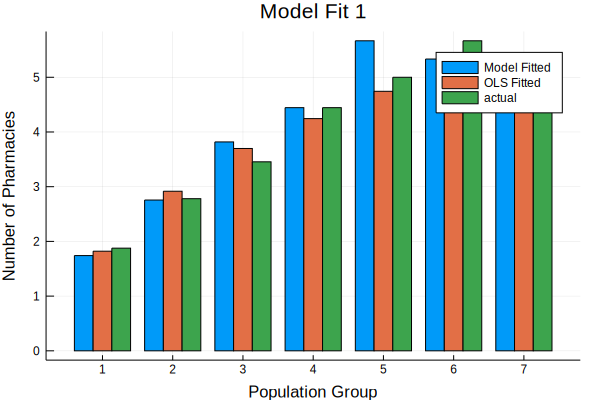

In [367]:
#Grouped Bar Chart

ph = df[:x1]
gr = df[:method]
pop = df[:group]

groupedbar(pop, ph, group = gr, ylabel = "Number of Pharmacies", 
        title = "Model Fit 1", xlabel = "Population Group")

So here we see a grouped bar that compares the average number of pharmcies for markets in each population group. So the first blue 
line represents the average number of pharmacies as predicted by the model in this paper for population centres that have between 
0-2500 people, and so forth. Overall, the correlations between fitted value number of pharmacies and actualy number of pharmacies observed in the data 
is 0.59 and 0.6 for this papers model and the standard OLS model, respectivley.


In [368]:
#Next Im going to make a grouped line graph to see how both models are capturing the 
#trends in number of pharmacies.

In [369]:
#To get the grouped line graph too work, I need the actual number of pharmacies and fitted number of pharmacies to be 
#number of pharmacies to be in the same column

In [370]:
#DataFrame for actual number of pharmacies
actual = DataFrame(Population = CleanData1[:pop2016], pharmacies = CleanData1[:pharmacies])
actual[:method] = "actual"
actual;

#DataFrame for fitted number of pharmacies using OLS
OLS = DataFrame(Population = CleanData1[:pop2016], pharmacies = CleanData1[:nhatO])
OLS[:method] = "OLS fitted"
OLS;

#DataFrame for fitted number of pharmacies using this paper's model
Model = DataFrame(Population = CleanData1[:pop2016], pharmacies = CleanData1[:nhat1])
Model[:method] = "Model fitted"
Model;

#Now combine them into a single dataframe

AllData = vcat(actual, OLS, Model);
AllData1 = AllData[AllData[:Population].<2000,:];

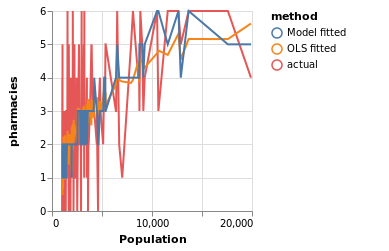

In [371]:
#Creating the line graph

AllData |>
@vlplot(:line,enc={x=:Population,y=:pharmacies,color=:method})

Obviously this looks pretty brutal. This issue is that there are too many data points with too much variation in 
the actual data, especially for low poppulation centres. Next im only going to use the first 25 datapoints to see if we can get something that has a bit better of an interpretation.


In [372]:
#cut the AllData datafrome down 

AllCut1 = AllData[1:25, [:Population, :pharmacies, :method]];
AllCut2 = AllData[151:175, [:Population, :pharmacies, :method]];
AllCut3 = AllData[301:325, [:Population, :pharmacies, :method]];

AllCutFinal = vcat(AllCut1, AllCut2, AllCut3);

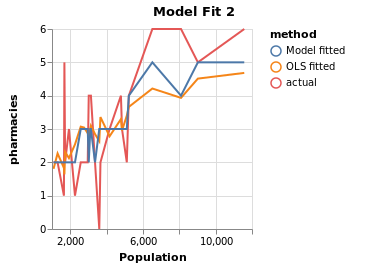

In [373]:
#Creating the line graph

AllCutFinal |>
@vlplot(:line,enc={x=:Population,y=:pharmacies,color=:method}, title = "Model Fit 2")

This is a little better. It is still somehwat difficult to see if either model is capturing the trend
in the data. We do see a large spike in the actual data once we hit a population of 6000, which looks to be captured
slightly better by our fitted model in comparison to the OLS fitted model. 


### Problem 5: Model Entry Thresholds

In [380]:
using ForwardDiff
# delta method demo
X = convert(Matrix, CleanData1[x])
W = convert(Matrix, CleanData1[w])
Xbar = mapslices(mean, X, dims = 1)
Wbar = mapslices(mean, W, dims = 1)

1×2 Array{Float64,2}:
 -0.295052  1.26234

In [391]:
function func_of_estimate(θ)
   (α, β, γ, δ) = unpack(θ)
    y = zeros(length(α))
    y[1] = (γ[1] + sum(Wbar.*δ)) / (sum(Xbar.*β) + α[1])
for i in 2:length(α)
    y[i] = (sum(γ[1:i])+ sum(Wbar.*δ)) / (sum(Xbar.*β) + sum(α[1:i]))
    end
    return(y)
end


func_of_estimate (generic function with 1 method)

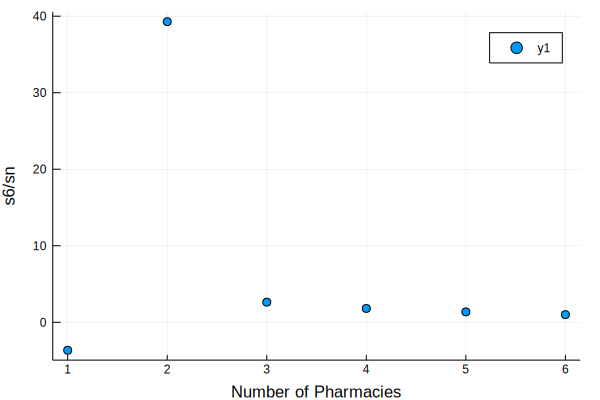

In [393]:
sn = func_of_estimate(θhat)
Sn = sn[length(sn)] ./ sn
a = [1:6]

scatter(a, Sn, xlabel = "Number of Pharmacies", ylabel = "s6/sn")

So this is somewhat consistent with what we would expect to find. In essance, 
this says that to support more firms we need a higher population. 